# Regressão Logística
### A regressão logística é um recurso que nos permite estimar a probabilidade associada à ocorrência de determinado evento em face de um conjunto de variáveis explanatórias.
### Características
• Busca estimar a probabilidade da variável
dependente assumir um determinado valor em
função dos conhecidos de outras variáveis.

• Os resultados da análise ficam contidos no
intervalo de zero a um.

#### Vamos montar um algoritmo de classificação sobrevivente ou falecido utilizando regressão logística no Python.

#### Usaremos uma versão "semi-limpa" do conjunto de dados do Titanic. Se você usar o conjunto de dados hospedado diretamente no Kaggle, talvez seja necessário fazer uma limpeza adicional não mostrada neste notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
train = pd.read_csv('titanic_train.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Dados ausentes

Podemos usar seaborn para criar um mapa de calor simples para ver onde estamos perdendo dados!

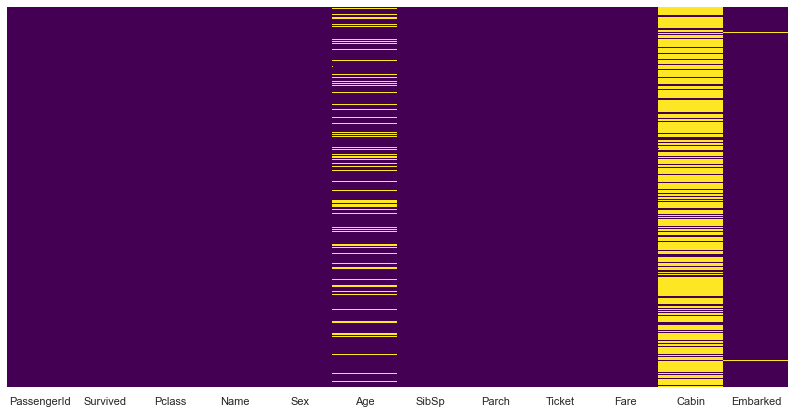

In [5]:
plt.figure(figsize=(14, 7))
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [6]:
sns.set_style('whitegrid')

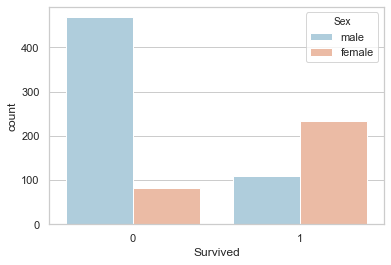

In [7]:
sns.countplot(x='Survived', data=train, hue='Sex', palette='RdBu_r')

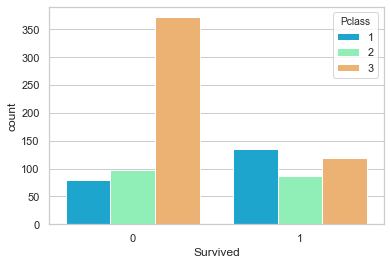

In [8]:
sns.countplot(x='Survived', data=train, hue='Pclass', palette='rainbow')

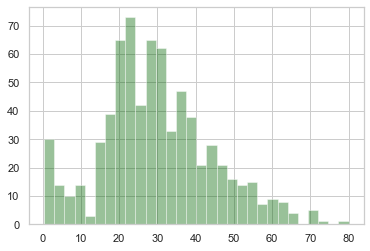

In [9]:
train['Age'].hist(bins=30, color='darkgreen',  alpha=0.4)

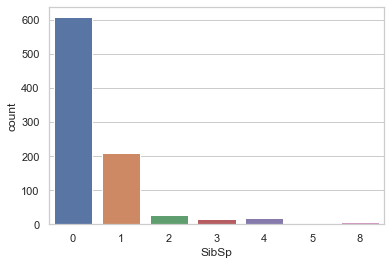

In [10]:
sns.countplot(x='SibSp', data=train)

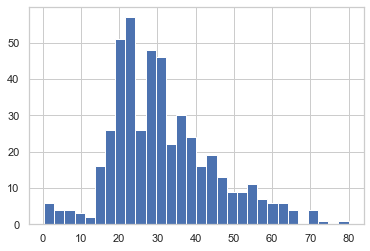

In [11]:
train[train['SibSp'] == 0]['Age'].hist(bins=30)

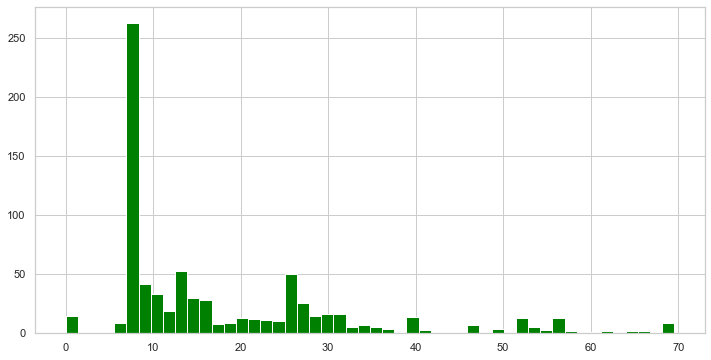

In [12]:
train[train['Fare']< 70]['Fare'].hist(color='green', bins=50, figsize=(12,6))

## Limpando os dados

Queremos preencher dados de idade faltantes, em vez de simplesmente deixar cair as linhas de dados de idade que faltam. Uma maneira de fazer isso é preenchendo a idade média de todos os passageiros (imputação).
No entanto, podemos ser mais inteligentes sobre isso e verificar a idade média pela classe de passageiros. Por exemplo:


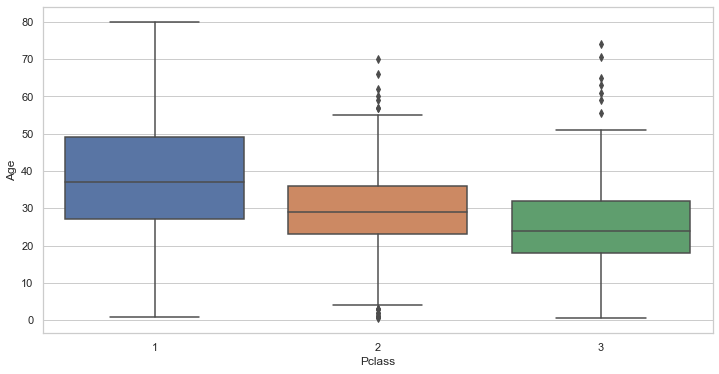

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Pclass', y='Age', data=train)

Podemos ver os passageiros mais ricos nas (que estão nas classes superiores) tendem a ser mais velhos, o que faz sentido. Usaremos esses valores de idade média para imputar com base em Pclass for Age.

In [14]:
def impute_idade(cols):
    Idade = cols[0]
    Classe = cols[1]
    
    if pd.isnull(Idade):
        if Classe == 1:
            return 37
        elif Classe == 2:
            return 29
        else:
            return 24
    else:
        return Idade

In [15]:
train['Age'] = train[['Age', 'Pclass']].apply(impute_idade, axis=1)

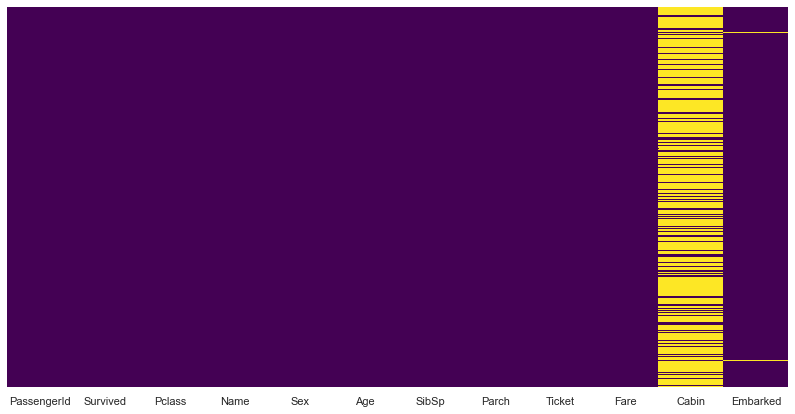

In [16]:
plt.figure(figsize=(14, 7))
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [17]:
del train['Cabin']
# trains.drop('Cabin, inplace=True')

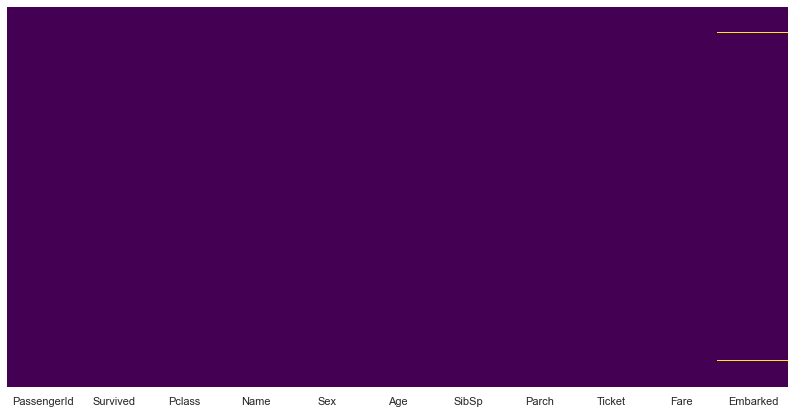

In [18]:
plt.figure(figsize=(14, 7))
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [19]:
train.dropna(inplace=True)

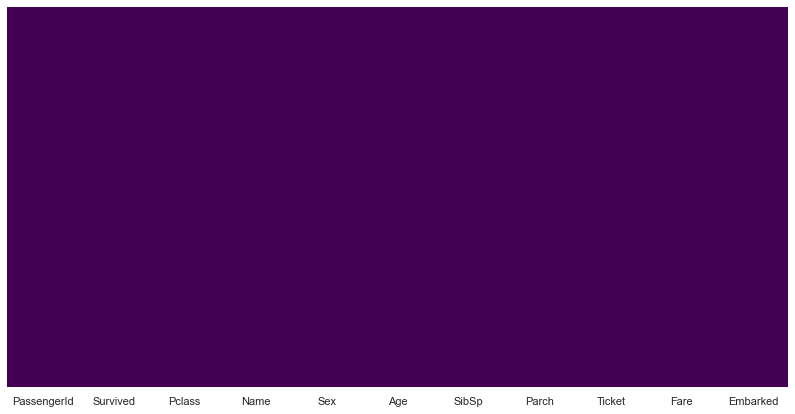

In [20]:
plt.figure(figsize=(14, 7))
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [21]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


## Convertendo recursos categóricos

Precisamos converter características categóricas em variáveis dummy usando pandas! Caso contrário, nosso algoritmo de Machine Learning não será capaz de aceitar esses recursos diretamente como entradas.

In [22]:
sex = pd.get_dummies(train['Sex'], drop_first=True)

In [23]:
embark = pd.get_dummies(train['Embarked'], drop_first=True)

In [24]:
embark

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1
...,...,...
886,0,1
887,0,1
888,0,1
889,0,0


In [25]:
train.drop(['Sex', 'PassengerId', 'Name', 'Ticket', 'Embarked'], axis=1, inplace=True)

In [26]:
train = pd.concat([train, sex, embark], axis=1)

In [27]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


# Construindo um modelo de Regressão Logística

Vamos começar dividindo nossos dados em um conjunto de treinamento e conjunto de testes (há outro arquivo test.csv que você pode usar ao invés, caso queira usar todos esses dados para treinar).

## Divisão treino-teste

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived', axis=1), train['Survived'], test_size=0.3)

## Training and Predicting

In [31]:
logmodel = LogisticRegression(max_iter=1200000)
logmodel.fit(X_train, y_train)

LogisticRegression(max_iter=1200000)

In [32]:
predictions = logmodel.predict(X_test)

# Avaliação

In [33]:
from sklearn.metrics import classification_report

In [34]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       177
           1       0.77      0.73      0.75        90

    accuracy                           0.84       267
   macro avg       0.82      0.81      0.81       267
weighted avg       0.83      0.84      0.83       267



In [35]:
from sklearn.metrics import confusion_matrix

In [36]:
print(confusion_matrix(y_test, predictions))

[[157  20]
 [ 24  66]]
